# VEGETABLE OIL

- https://bashtage.github.io/linearmodels/iv/introduction.html

Cap 15 Wooldridge - pg 494

In [1]:
# !pip install linearmodels fredapi --quiet

In [1]:
import pandas as pd
import numpy as np
import linearmodels
import tabulate
import requests
import dateutil.parser

pd.set_option('display.max_columns', None)

# Leitura do Dataset

In [2]:
def get_main():
    df = pd.read_csv('https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/COMM5__v4.csv', skiprows=1)
    print(df.shape)
    df['const'] = 1
    df.dropna(axis=1, how='all')
    print(df.shape)

    df['date'] = pd.to_datetime(df['date'])
    # df['date'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d'))
    df.set_index('date', inplace=True)
    
#     return df
    return  df[df.index < '2021-01-01']

df_main = get_main()
df_main.head()


(245, 114)
(245, 115)


,reference,A_exports,A_price,A_production,A_share_PROD,A_share_export,A_ΔP,A_ΔQ,A_Cuzada,A_Elasticidade,A_vol_prod,A_vol_exp,A_PnQo,A_balance,B_exports,B_price,B_production,B_share_PROD,B_share_export,B_ΔP,B_ΔQ,B_Cuzada,B_Elasticidade,B_vol_prod,B_vol_exp,B_PnQo,B_balance,C_exports,C_price,C_production,C_share_PROD,C_share_export,C_ΔP,C_ΔQ,C_Cuzada,C_Elasticidade,C_vol_prod,C_vol_exp,C_PnQo,C_balance,D_exports,D_price,D_production,D_share_PROD,D_share_export,D_ΔP,D_ΔQ,D_Cuzada,D_Elasticidade,D_vol_prod,D_vol_exp,D_PnQo,D_balance,E_exports,E_price,E_production,E_share_PROD,E_share_export,E_ΔP,E_ΔQ,E_Cuzada,E_Elasticidade,E_vol_prod,E_vol_exp,E_PnQo,E_balance,prod_total,exp_total,vol_prod_total,vol_expo_total,ΔP_total,ΔQ_total,elasticidade_total,ΣPnQo_total,price_total_exp,price_total_prod,FK IDX CALC PROD,FK IDX CALC EXP,Δ IDX/FAO,FK IDX 5 COMM,Δ IDX/FAO.1,FK IDX 7 COMM,Δ IDX/FAO.2,vegetable-oil_price,vegetable-oil_exports,EXPORT\nDIF USDA,EXPORT\nCALC/USDA,vegetable-oil_production,VOL PROD \nCALC/USDA,vegetable-oil_oecd_exports,EXPORT \nDIF OECD,EXPORT \nCALC/OECD,vegetable-oil_oecd_production,VOL PROD\nCALC/OECD,fred_price_idx,index_mundi_dap,bloomberg_price_index,africa_eastern_and_southern_income,east_asia_and_pacific_income,europe_and_central_asia_income,high_income_income,latin_america_and_caribbean_income,least_developed_countries_un_classification_income,low_income_income,lower_middle_income_income,middle_east_and_north_africa_income,middle_income_income,north_america_income,oecd_members_income,south_asia_income,sub-saharan_africa_income,upper_middle_income_income,world_income,const
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,World,264.00,1224.868,699.42,4.07,3.7,0.132,-0.003,-0.302,0.024,856697.1766,323365.1520,324455.2845,37.7,4004.50,1016.374,6089.33,35.42,56.30,0.102,-0.001,0.699,0.007,6189036.689,4070069.683,3955036.474,65.8,531.92,1097.626,2427.75,14.12,7.50,0.046,0.007,0.0,0.144,2664761.522,583849.2219,368297.4280,21.9,1640.17,1026.196,6381.50,37.12,23.10,0.052,0.000,0.0,0.007,6548669.774,1683135.893,1578166.304,25.7,936.67,1170.020,1592.42,9.26,13.20,0.053,-0.016,0.0,0.307,1863163.248,1.095923e+06,731215.6992,58.8,17190.42,7113.26,18122328.41,7756342.584,0.072,0.079,1.097,6957171.190,1090.406169,1054.210916,128.238,135.707,0.977,130.114,0.992,129.912071,0.990,131.199,7689.17,575.91,0.925101,18658.00,0.921343,7301.11,187.85,0.974271,17908.53,0.959901,307.5,388.50,410.8200,90.78,719.03,1617.02,2997.18,465.82,78.12,47.99,158.83,466.45,337.13,4280.70,2604.18,135.62,100.54,572.53,730.62,1
2020-11-30,World,264.85,1073.480,700.35,4.08,3.6,0.285,-0.003,-0.007,0.011,751811.7180,284311.1780,284354.1172,37.8,4007.22,917.810,6088.80,35.43,54.21,0.113,-0.001,0.028,0.006,5588361.528,3677866.588,3571492.409,65.8,528.37,1047.780,2420.51,14.08,7.15,0.122,0.007,0.0,0.055,2536161.968,553615.5186,351572.1012,21.8,1639.60,973.880,6369.82,37.06,22.18,0.063,0.000,0.0,0.006,6203440.302,1596773.648,1497710.574,25.7,952.17,1109.112,1606.51,9.35,12.88,0.122,-0.016,0.0,0.132,1781799.519,1.056063e+06,693150.6355,59.3,17185.99,7392.21,16861575.03,7168630.106,0.103,0.108,1.042,6398279.838,969.754661,981.120000,119.347,120.691,0.979,119.662,0.982,119.158129,0.977,121.903,7704.28,312.07,0.959494,18655.97,0.921206,7289.46,-102.75,1.014096,17889.58,0.960670,292.1,359.63,384.9375,91.87,719.85,1623.89,3008.33,474.11,78.25,48.15,159.62,470.50,338.77,4296.22,2614.47,136.48,101.34,575.12,733.87,1
2020-10-31,World,265.71,805.910,701.28,4.08,3.6,0.048,-0.003,-0.041,0.066,565168.5648,214138.3461,213477.4999,37.9,4009.93,819.270,6088.26,35.43,54.14,0.029,-0.001,0.110,0.024,4987928.770,3285215.351,3188041.736,65.9,524.82,927.710,2413.26,14.05,7.09,-0.011,0.007,0.0,0.607,2238805.435,486880.7622,311283.8134,21.7,1639.03,914.770,6358.14,37.01,22.13,0.010,0.000,0.0,0.036,5816235.728,1499335.473,1406806.488,25.8,967.67,981.402,1620.61,9.43,13.06,-0.001,-0.016,0.0,15.873,159046

In [3]:
[col for col in df_main.columns.to_list() if 'total' in col]

['prod_total',
 'exp_total',
 'vol_prod_total',
 'vol_expo_total',
 'ΔP_total',
 'ΔQ_total',
 'elasticidade_total',
 'ΣPnQo_total',
 'price_total_exp',
 'price_total_prod']

In [4]:
df = df_main[['const', 'exp_total', 'price_total_exp', 'index_mundi_dap', 'world_income']]
df

,const,exp_total,price_total_exp,index_mundi_dap,world_income
date,,,,,
2020-12-31,1,7113.26,1090.406169,388.50,730.62
2020-11-30,1,7392.21,969.754661,359.63,733.87
2020-10-31,1,7407.16,868.786850,357.10,737.12
2020-09-30,1,7422.11,854.031898,358.38,740.37
2020-08-31,1,7437.06,809.940713,341.88,743.62
...,...,...,...,...,...
2002-04-30,1,3151.41,377.847906,147.80,384.42
2002-03-31,1,3123.33,371.064871,149.75,383.43
2002-02-28,1,3095.25,371.687118,150.25,382.43


# OLS - DEMANDA - Tentiva # 1


In [5]:
# A variavel endogena vira Y
y1 = df['exp_total']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', 'price_total_exp', 'world_income', 'index_mundi_dap']]

In [6]:
#encontra o Z chapeu
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error    
import statsmodels.api as sm

# Preciso do treino e teste aqui para capturar r2
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
z_hat = lr_modelo.predict(X1)

In [7]:
X2 = df[['const', 'price_total_exp', 'world_income']]
X2['z_hat'] = z_hat
X2

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\630864062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['z_hat'] = z_hat


,const,price_total_exp,world_income,z_hat
date,,,,
2020-12-31,1,1090.406169,730.62,5919.270623
2020-11-30,1,969.754661,733.87,6229.251770
2020-10-31,1,868.786850,737.12,6479.948825
2020-09-30,1,854.031898,740.37,6550.126979
2020-08-31,1,809.940713,743.62,6693.425207
...,...,...,...,...
2002-04-30,1,377.847906,384.42,3229.129972
2002-03-31,1,371.064871,383.43,3229.353014
2002-02-28,1,371.687118,382.43,3215.206055


In [8]:
ols_model = sm.OLS(y1,X2)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:              exp_total   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     500.2
Date:                Sun, 15 May 2022   Prob (F-statistic):           3.27e-99
Time:                        19:03:38   Log-Likelihood:                -1736.6
No. Observations:                 229   AIC:                             3481.
Df Residuals:                     225   BIC:                             3495.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.292e-12    317.584   1.

# Demanda em duas etapas

P_HAT

In [9]:
# EQ Reduzida

y1 = df['price_total_exp']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', 'world_income', 'index_mundi_dap']]
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
p_hat = lr_modelo.predict(X1)

# EQ Estrutural
y2 = df['exp_total']
X2 = df[['const', 'world_income']]
X2['price_hat'] = p_hat

print('DEMANDA')
ols_model = sm.OLS(y2,X2)
ols_results = ols_model.fit()
print(ols_results.summary())

DEMANDA
                            OLS Regression Results                            
Dep. Variable:              exp_total   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     513.8
Date:                Sun, 15 May 2022   Prob (F-statistic):           8.42e-85
Time:                        19:03:40   Log-Likelihood:                -1773.7
No. Observations:                 229   AIC:                             3553.
Df Residuals:                     226   BIC:                             3564.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -653.9710    201.914     -

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\968486971.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['price_hat'] = p_hat


# Demanda por IV-2SLS

In [10]:
# https://github.com/rachelsng/Train-Travel-Demand-Modelling-in-Python/blob/main/02_Demand_Modelling_with_2SLS.ipynb

# Homoskedastic
df_1 = df.copy()

dependent = df_1['exp_total']
exog = df_1.drop(['exp_total', 'price_total_exp', 'index_mundi_dap'], axis=1)
exog = sm.add_constant(exog)
endog = df_1[['price_total_exp']]
instruments = df_1[['index_mundi_dap']]
sm_2sls = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instruments).fit(
    cov_type="unadjusted"
)

print(sm_2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              exp_total   R-squared:                      0.8621
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8609
No. Observations:                 229   F-statistic:                    1361.0
Date:                Sun, May 15 2022   P-value (F-stat)                0.0000
Time:                        19:03:43   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const              -653.97     175.44    -3.7276     0.0002     -997.83     -310.12
world_income        13.027     0

In [11]:
# Heteroskedastic
sm_2sls = linearmodels.IV2SLS(dependent, exog, endog, instruments).fit(cov_type="robust")
print(sm_2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              exp_total   R-squared:                      0.8621
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8609
No. Observations:                 229   F-statistic:                    3029.5
Date:                Sun, May 15 2022   P-value (F-stat)                0.0000
Time:                        19:03:45   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const              -653.97     103.85    -6.2974     0.0000     -857.51     -450.43
world_income        13.027     0

# OFERTA em duas etapas

Q_HAT

In [12]:
# EQ Reduzida

y1 = df['price_total_exp']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', 'world_income', 'index_mundi_dap']]
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
p_hat = lr_modelo.predict(X1)

# EQ Estrutural
y2 = df['exp_total']
X2 = df[['const', 'index_mundi_dap']]
X2['price_hat'] = p_hat

print('OFERTA')
ols_model = sm.OLS(y2,X2)
ols_results = ols_model.fit()
print(ols_results.summary())

OFERTA
                            OLS Regression Results                            
Dep. Variable:              exp_total   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     513.8
Date:                Sun, 15 May 2022   Prob (F-statistic):           8.42e-85
Time:                        19:03:46   Log-Likelihood:                -1773.7
No. Observations:                 229   AIC:                             3553.
Df Residuals:                     226   BIC:                             3564.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1694.7434    230.2

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\3075232393.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['price_hat'] = p_hat


# Oferta por IV-2SLS

In [13]:
# https://github.com/rachelsng/Train-Travel-Demand-Modelling-in-Python/blob/main/02_Demand_Modelling_with_2SLS.ipynb
df_1 = df.copy()

dependent = df_1['exp_total']
exog = df_1.drop(['exp_total', 'price_total_exp', 'world_income'], axis=1)
exog = sm.add_constant(exog)
endog = df_1[['price_total_exp']]
instruments = df_1[['world_income']]

sm_2sls = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instruments).fit(
    cov_type="unadjusted"
)

print(sm_2sls)


                          IV-2SLS Estimation Summary                          
Dep. Variable:              exp_total   R-squared:                     -3.5221
Estimator:                    IV-2SLS   Adj. R-squared:                -3.5621
No. Observations:                 229   F-statistic:                    41.510
Date:                Sun, May 15 2022   P-value (F-stat)                0.0000
Time:                        19:03:49   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const              -1694.7     1145.4    -1.4796     0.1390     -3939.7      550.19
index_mundi_dap    -17.843     3

# Statsmodels

In [19]:
from statsmodels.sandbox.regression.gmm import IV2SLS


endo = df_1[['exp_total']]

exog = df_1.drop(['exp_total', 'price_total_exp', 'index_mundi_dap'], axis=1)
exog = sm.add_constant(exo)

# iv = df_1[['index_mundi_dap','world_income']]
# results = IV2SLS(endog=endog,exog=exog,instrument=instrument).fit()
# print(results.summary())


# y1 = df_1['exp_total']
# exog = df_1.drop(['exp_total', 'price_total_exp', 'world_income'], axis=1)
# exog = sm.add_constant(exog)
# endog = df_1[['price_total_exp']]
# instrument = df_1[['world_income']]


# endog = df[["exp_total"]]
# exog = df[['index_mundi_dap', "price_total_exp"]]
# instrument = df[['world_income']]
# results = IV2SLS(endog=endog,exog=exog,instrument=instrument).fit()
# print(results.summary())
# iv

# 2SLS


In [22]:
df

,const,exp_total,price_total_exp,index_mundi_dap,world_income
date,,,,,
2020-12-31,1,7113.26,1090.406169,388.50,730.62
2020-11-30,1,7392.21,969.754661,359.63,733.87
2020-10-31,1,7407.16,868.786850,357.10,737.12
2020-09-30,1,7422.11,854.031898,358.38,740.37
2020-08-31,1,7437.06,809.940713,341.88,743.62
...,...,...,...,...,...
2002-04-30,1,3151.41,377.847906,147.80,384.42
2002-03-31,1,3123.33,371.064871,149.75,383.43
2002-02-28,1,3095.25,371.687118,150.25,382.43


In [42]:
def compare_models(df, explicada, explicativa, endogena, VI):
    dados = df.copy()


    dependent = dados[explicada]
    exog = dados[explicativa + endogena]
    exog = sm.add_constant(exog)
    endog = None
    instrument = None
    res_ols  = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instrument).fit(cov_type="robust")

    
    
#     dependent = dados[endogena]
#     exog = dados[explicativa]
#     exog = sm.add_constant(exog)
#     endog = None
#     instrument = None
#     res_first = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instrument).fit(cov_type="unadjusted")

#     dados["z_hat"] = dados[explicada] - res_first.resids
#     # dados[[explicativa, 'z_hat']].tail()

#     dependent = dados[explicada]
#     exog = dados[['z_hat']]
#     exog = sm.add_constant(exog)
#     endog = dados[[explicativa]]
#     instrument = dados[[VI]]
#     res_second = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instrument).fit(cov_type="robust")

    
    
    dependent = dados[explicada]
    exog = dados[explicativa]
    exog = sm.add_constant(exog)
    endog = dados[endogena]
    instrument = dados[VI]
    res_2sls = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instrument).fit(cov_type="robust")


    # print(linearmodels.iv.compare({"OLS": res_ols, "First": res_first , "2SLS": res_second, "Direct": res_direct}))
    print(linearmodels.iv.compare({"OLS": res_ols, "2SLS": res_2sls}))
    return res_2sls



x= compare_models(df, explicada= 'exp_total', explicativa= ['world_income'], endogena= ['price_total_exp'], VI=['index_mundi_dap'] )



                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable            exp_total         exp_total
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.8664            0.8621
Adj. R-squared              0.8652            0.8609
F-statistic                 3139.4            3029.5
P-value (F-stat)            0.0000            0.0000
==================     ===========       ===========
const                      -628.44           -653.97
                         (-6.3617)         (-6.2974)
world_income                12.428            13.027
                          (45.373)          (23.034)
price_total_exp            -2.4038           -2.8637
                         (-14.292)         (-6.8718)
==================== ============= ===========

# Achar Quantidade

## GIRASSOL

In [20]:
df_main.head()

,reference,A_exports,A_price,A_production,A_share_PROD,A_share_export,A_ΔP,A_ΔQ,A_Cuzada,A_Elasticidade,A_vol_prod,A_vol_exp,A_PnQo,A_balance,B_exports,B_price,B_production,B_share_PROD,B_share_export,B_ΔP,B_ΔQ,B_Cuzada,B_Elasticidade,B_vol_prod,B_vol_exp,B_PnQo,B_balance,C_exports,C_price,C_production,C_share_PROD,C_share_export,C_ΔP,C_ΔQ,C_Cuzada,C_Elasticidade,C_vol_prod,C_vol_exp,C_PnQo,C_balance,D_exports,D_price,D_production,D_share_PROD,D_share_export,D_ΔP,D_ΔQ,D_Cuzada,D_Elasticidade,D_vol_prod,D_vol_exp,D_PnQo,D_balance,E_exports,E_price,E_production,E_share_PROD,E_share_export,E_ΔP,E_ΔQ,E_Cuzada,E_Elasticidade,E_vol_prod,E_vol_exp,E_PnQo,E_balance,prod_total,exp_total,vol_prod_total,vol_expo_total,ΔP_total,ΔQ_total,elasticidade_total,ΣPnQo_total,price_total_exp,price_total_prod,FK IDX CALC PROD,FK IDX CALC EXP,Δ IDX/FAO,FK IDX 5 COMM,Δ IDX/FAO.1,FK IDX 7 COMM,Δ IDX/FAO.2,vegetable-oil_price,vegetable-oil_exports,EXPORT\nDIF USDA,EXPORT\nCALC/USDA,vegetable-oil_production,VOL PROD \nCALC/USDA,vegetable-oil_oecd_exports,EXPORT \nDIF OECD,EXPORT \nCALC/OECD,vegetable-oil_oecd_production,VOL PROD\nCALC/OECD,fred_price_idx,index_mundi_dap,bloomberg_price_index,africa_eastern_and_southern_income,east_asia_and_pacific_income,europe_and_central_asia_income,high_income_income,latin_america_and_caribbean_income,least_developed_countries_un_classification_income,low_income_income,lower_middle_income_income,middle_east_and_north_africa_income,middle_income_income,north_america_income,oecd_members_income,south_asia_income,sub-saharan_africa_income,upper_middle_income_income,world_income,const
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,World,264.00,1224.868,699.42,4.07,3.7,0.132,-0.003,-0.302,0.024,856697.1766,323365.1520,324455.2845,37.7,4004.50,1016.374,6089.33,35.42,56.30,0.102,-0.001,0.699,0.007,6189036.689,4070069.683,3955036.474,65.8,531.92,1097.626,2427.75,14.12,7.50,0.046,0.007,0.0,0.144,2664761.522,583849.2219,368297.4280,21.9,1640.17,1026.196,6381.50,37.12,23.10,0.052,0.000,0.0,0.007,6548669.774,1683135.893,1578166.304,25.7,936.67,1170.020,1592.42,9.26,13.20,0.053,-0.016,0.0,0.307,1863163.248,1.095923e+06,731215.6992,58.8,17190.42,7113.26,18122328.41,7756342.584,0.072,0.079,1.097,6957171.190,1090.406169,1054.210916,128.238,135.707,0.977,130.114,0.992,129.912071,0.990,131.199,7689.17,575.91,0.925101,18658.00,0.921343,7301.11,187.85,0.974271,17908.53,0.959901,307.5,388.50,410.8200,90.78,719.03,1617.02,2997.18,465.82,78.12,47.99,158.83,466.45,337.13,4280.70,2604.18,135.62,100.54,572.53,730.62,1
2020-11-30,World,264.85,1073.480,700.35,4.08,3.6,0.285,-0.003,-0.007,0.011,751811.7180,284311.1780,284354.1172,37.8,4007.22,917.810,6088.80,35.43,54.21,0.113,-0.001,0.028,0.006,5588361.528,3677866.588,3571492.409,65.8,528.37,1047.780,2420.51,14.08,7.15,0.122,0.007,0.0,0.055,2536161.968,553615.5186,351572.1012,21.8,1639.60,973.880,6369.82,37.06,22.18,0.063,0.000,0.0,0.006,6203440.302,1596773.648,1497710.574,25.7,952.17,1109.112,1606.51,9.35,12.88,0.122,-0.016,0.0,0.132,1781799.519,1.056063e+06,693150.6355,59.3,17185.99,7392.21,16861575.03,7168630.106,0.103,0.108,1.042,6398279.838,969.754661,981.120000,119.347,120.691,0.979,119.662,0.982,119.158129,0.977,121.903,7704.28,312.07,0.959494,18655.97,0.921206,7289.46,-102.75,1.014096,17889.58,0.960670,292.1,359.63,384.9375,91.87,719.85,1623.89,3008.33,474.11,78.25,48.15,159.62,470.50,338.77,4296.22,2614.47,136.48,101.34,575.12,733.87,1
2020-10-31,World,265.71,805.910,701.28,4.08,3.6,0.048,-0.003,-0.041,0.066,565168.5648,214138.3461,213477.4999,37.9,4009.93,819.270,6088.26,35.43,54.14,0.029,-0.001,0.110,0.024,4987928.770,3285215.351,3188041.736,65.9,524.82,927.710,2413.26,14.05,7.09,-0.011,0.007,0.0,0.607,2238805.435,486880.7622,311283.8134,21.7,1639.03,914.770,6358.14,37.01,22.13,0.010,0.000,0.0,0.036,5816235.728,1499335.473,1406806.488,25.8,967.67,981.402,1620.61,9.43,13.06,-0.001,-0.016,0.0,15.873,159046

In [70]:
df_gir = df_main[['E_exports', 'E_price', 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_gir, explicada= 'E_exports', explicativa= ['world_income'], endogena= ['E_price'], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_gir, explicada= 'E_exports', explicativa= ['index_mundi_dap'], endogena= ['E_price'], VI=['world_income'] )

DEMANDA
                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable            E_exports         E_exports
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.7493            0.7424
Adj. R-squared              0.7471            0.7401
F-statistic                 972.48            1026.8
P-value (F-stat)            0.0000            0.0000
==================     ===========       ===========
const                      -532.98           -529.51
                         (-16.875)         (-16.884)
world_income                2.2821            2.3949
                          (27.954)          (20.015)
E_price                    -0.4552           -0.5377
                         (-12.985)         (-7.1251)
==================== ============= ===

In [72]:
df_gir['q_d'] = d.params['const'] + d.params['E_price']*df_gir['E_price'] + d.params['world_income']*df_gir['world_income']
df_gir

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1999923629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir['q_d'] = d.params['const'] + d.params['E_price']*df_gir['E_price'] + d.params['world_income']*df_gir['world_income']


,E_exports,E_price,index_mundi_dap,world_income,q_d
date,,,,,
2020-12-31,936.67,1170.020,388.50,730.62,591.129697
2020-11-30,952.17,1109.112,359.63,733.87,631.661809
2020-10-31,967.67,981.402,357.10,737.12,708.111820
2020-09-30,983.17,982.385,358.38,740.37,715.366564
2020-08-31,998.67,877.140,341.88,743.62,779.737661
...,...,...,...,...,...
2002-04-30,171.53,552.000,147.80,384.42,94.325838
2002-03-31,168.85,557.000,149.75,383.43,89.266546
2002-02-28,166.18,578.000,150.25,382.43,75.580473


In [73]:
df_gir['q_o'] = o.params['const'] + o.params['E_price']*df_gir['E_price'] + o.params['index_mundi_dap']*df_gir['index_mundi_dap']
df_gir

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\3606033687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir['q_o'] = o.params['const'] + o.params['E_price']*df_gir['E_price'] + o.params['index_mundi_dap']*df_gir['index_mundi_dap']


,E_exports,E_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,936.67,1170.020,388.50,730.62,591.129697,1869.027665
2020-11-30,952.17,1109.112,359.63,733.87,631.661809,1752.205184
2020-10-31,967.67,981.402,357.10,737.12,708.111820,911.278648
2020-09-30,983.17,982.385,358.38,740.37,715.366564,904.799706
2020-08-31,998.67,877.140,341.88,743.62,779.737661,359.909220
...,...,...,...,...,...,...
2002-04-30,171.53,552.000,147.80,384.42,94.325838,146.925735
2002-03-31,168.85,557.000,149.75,383.43,89.266546,160.830899
2002-02-28,166.18,578.000,150.25,382.43,75.580473,298.245823


## Soybean

In [74]:
df_soy = df_main[['D_exports', 'D_price', 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_soy, explicada= 'D_exports', explicativa= ['world_income'], endogena= ['D_price'], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_soy, explicada= 'D_exports', explicativa= ['index_mundi_dap'], endogena= ['D_price'], VI=['world_income'] )

DEMANDA
                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable            D_exports         D_exports
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.2817            0.2658
Adj. R-squared              0.2754            0.2593
F-statistic                 68.842            28.565
P-value (F-stat)          1.11e-15         6.267e-07
==================     ===========       ===========
const                       1259.9            1265.1
                          (33.120)          (32.443)
world_income                0.6982            0.5694
                          (8.1271)          (5.3438)
D_price                    -0.3733           -0.2801
                         (-7.1602)         (-4.3737)
==================== ============= ===

In [75]:
df_soy['q_d'] = d.params['const'] + d.params['D_price']*df_soy['D_price'] + d.params['world_income']*df_soy['world_income']
df_soy

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\3421944604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soy['q_d'] = d.params['const'] + d.params['D_price']*df_soy['D_price'] + d.params['world_income']*df_soy['world_income']


,D_exports,D_price,index_mundi_dap,world_income,q_d
date,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684
...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787


In [76]:
df_soy['q_o'] = o.params['const'] + o.params['D_price']*df_soy['D_price'] + o.params['index_mundi_dap']*df_soy['index_mundi_dap']
df_soy

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\2773849868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soy['q_o'] = o.params['const'] + o.params['D_price']*df_soy['D_price'] + o.params['index_mundi_dap']*df_soy['index_mundi_dap']


,D_exports,D_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1429.385811
...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1297.619985


## Canola

In [78]:
EXP = 'C_exports'
PRIC = 'C_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable            C_exports         C_exports
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.8332            0.8222
Adj. R-squared              0.8318            0.8206
F-statistic                 1722.5            1782.1
P-value (F-stat)            0.0000            0.0000
==================     ===========       ===========
const                      -304.53           -300.59
                         (-23.740)         (-23.936)
world_income                1.1781            1.2719
                          (36.935)          (26.470)
C_price                    -0.2126           -0.2851
                         (-16.140)         (-9.2927)
==================== ============= ===

In [82]:
df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
df_temp

df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']


,C_exports,C_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,531.92,1097.626,388.50,730.62,315.734802,594.744218
2020-11-30,528.37,1047.780,359.63,733.87,334.079769,560.589457
2020-10-31,524.82,927.710,357.10,737.12,372.445972,339.690233
2020-09-30,521.27,938.140,358.38,740.37,373.605930,356.685606
2020-08-31,517.72,921.550,341.88,743.62,382.469433,359.573911
...,...,...,...,...,...,...
2002-04-30,82.75,410.770,147.80,384.42,71.236669,-200.913479
2002-03-31,83.60,415.850,149.75,383.43,68.529174,-195.379993
2002-02-28,84.46,423.450,150.25,382.43,65.090495,-182.100922


## PALM

In [85]:
EXP = 'B_exports'
PRIC = 'B_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable            B_exports         B_exports
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.9022            0.8974
Adj. R-squared              0.9013            0.8965
F-statistic                 4301.3            3810.7
P-value (F-stat)            0.0000            0.0000
==================     ===========       ===========
const                      -994.17           -1016.1
                         (-16.362)         (-15.474)
world_income                7.6907            8.0809
                          (57.857)          (26.853)
B_price                    -1.2043           -1.5209
                         (-14.918)         (-6.4892)
==================== ============= ===

In [86]:
df_temp

,B_exports,B_price,index_mundi_dap,world_income
date,,,,
2020-12-31,4004.50,1016.374,388.50,730.62
2020-11-30,4007.22,917.810,359.63,733.87
2020-10-31,4009.93,819.270,357.10,737.12
2020-09-30,4012.65,796.220,358.38,740.37
2020-08-31,4015.36,760.300,341.88,743.62
...,...,...,...,...
2002-04-30,1559.83,360.070,147.80,384.42
2002-03-31,1543.88,359.000,149.75,383.43
2002-02-28,1527.92,352.980,150.25,382.43


In [84]:
df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
df_temp

df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']


,B_exports,B_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,4004.50,1016.374,388.50,730.62,3342.116889,6008.006875
2020-11-30,4007.22,917.810,359.63,733.87,3518.285845,5203.865010
2020-10-31,4009.93,819.270,357.10,737.12,3694.418299,4133.235734
2020-09-30,4012.65,796.220,358.38,740.37,3755.737928,3863.842885
2020-08-31,4015.36,760.300,341.88,743.62,3836.631554,3631.336364
...,...,...,...,...,...,...
2002-04-30,1559.83,360.070,147.80,384.42,1542.689909,1144.318266
2002-03-31,1543.88,359.000,149.75,383.43,1536.317203,1112.666248
2002-02-28,1527.92,352.980,150.25,382.43,1537.392148,1040.630441


## PALM KERNEL

In [87]:
EXP = 'A_exports'
PRIC = 'A_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable            A_exports         A_exports
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.9486            0.9420
Adj. R-squared              0.9482            0.9415
F-statistic                 6569.1            5048.7
P-value (F-stat)            0.0000            0.0000
==================     ===========       ===========
const                      -4.1130           -7.3971
                         (-1.5340)         (-2.3058)
world_income                0.3804            0.4027
                          (76.606)          (29.503)
A_price                    -0.0166           -0.0290
                         (-6.8032)         (-3.8650)
==================== ============= ===

In [88]:
df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
df_temp

df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']


,A_exports,A_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,264.00,1224.868,388.50,730.62,251.341121,311.476481
2020-11-30,264.85,1073.480,359.63,733.87,257.039475,275.069189
2020-10-31,265.71,805.910,357.10,737.12,266.106482,200.640526
2020-09-30,266.56,767.840,358.38,740.37,268.519224,189.709881
2020-08-31,267.42,739.170,341.88,743.62,270.659418,185.108346
...,...,...,...,...,...,...
2002-04-30,131.19,405.000,147.80,384.42,135.682928,131.839987
2002-03-31,130.83,353.240,149.75,383.43,136.784972,116.935081
2002-02-28,130.47,356.000,150.25,382.43,136.302203,117.604308


## PROXY

In [135]:
EXP = 'exp_total'
PRIC = 'price_total_exp'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable            exp_total         exp_total
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.8664            0.8621
Adj. R-squared              0.8652            0.8609
F-statistic                 3139.4            3029.5
P-value (F-stat)            0.0000            0.0000
==================     ===========       ===========
const                      -628.44           -653.97
                         (-6.3617)         (-6.2974)
world_income                12.428            13.027
                          (45.373)          (23.034)
price_total_exp            -2.4038           -2.8637
                         (-14.292)         (-6.8718)
==================== ============= ===

In [136]:
df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
df_temp

df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.params['const'] + d.params[PRIC]*df_temp[PRIC] + d.params['world_income']*df_temp['world_income']
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1483166947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.params['const'] + o.params[PRIC]*df_temp[PRIC] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']


,exp_total,price_total_exp,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62,5741.092891,10222.468602
2020-11-30,7392.21,969.754661,359.63,733.87,6128.937020,8651.968832
2020-10-31,7407.16,868.786850,357.10,737.12,6460.413383,6951.752305
2020-09-30,7422.11,854.031898,358.38,740.37,6545.003893,6673.855426
2020-08-31,7437.06,809.940713,341.88,743.62,6713.603922,6206.085947
...,...,...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42,3271.754302,2199.703199
2002-03-31,3123.33,371.064871,149.75,383.43,3278.282203,2047.656606
2002-02-28,3095.25,371.687118,150.25,382.43,3263.473496,2049.491620


In [137]:
df_temp['q_m'] = (df_temp['q_d'] + df_temp['q_o'])/2
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1833797238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_m'] = (df_temp['q_d'] + df_temp['q_o'])/2


,exp_total,price_total_exp,index_mundi_dap,world_income,q_d,q_o,q_m
date,,,,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62,5741.092891,10222.468602,7981.780746
2020-11-30,7392.21,969.754661,359.63,733.87,6128.937020,8651.968832,7390.452926
2020-10-31,7407.16,868.786850,357.10,737.12,6460.413383,6951.752305,6706.082844
2020-09-30,7422.11,854.031898,358.38,740.37,6545.003893,6673.855426,6609.429660
2020-08-31,7437.06,809.940713,341.88,743.62,6713.603922,6206.085947,6459.844934
...,...,...,...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42,3271.754302,2199.703199,2735.728750
2002-03-31,3123.33,371.064871,149.75,383.43,3278.282203,2047.656606,2662.969404
2002-02-28,3095.25,371.687118,150.25,382.43,3263.473496,2049.491620,2656.482558


# Achar Preço

In [93]:
df_main.head()

,reference,A_exports,A_price,A_production,A_share_PROD,A_share_export,A_ΔP,A_ΔQ,A_Cuzada,A_Elasticidade,A_vol_prod,A_vol_exp,A_PnQo,A_balance,B_exports,B_price,B_production,B_share_PROD,B_share_export,B_ΔP,B_ΔQ,B_Cuzada,B_Elasticidade,B_vol_prod,B_vol_exp,B_PnQo,B_balance,C_exports,C_price,C_production,C_share_PROD,C_share_export,C_ΔP,C_ΔQ,C_Cuzada,C_Elasticidade,C_vol_prod,C_vol_exp,C_PnQo,C_balance,D_exports,D_price,D_production,D_share_PROD,D_share_export,D_ΔP,D_ΔQ,D_Cuzada,D_Elasticidade,D_vol_prod,D_vol_exp,D_PnQo,D_balance,E_exports,E_price,E_production,E_share_PROD,E_share_export,E_ΔP,E_ΔQ,E_Cuzada,E_Elasticidade,E_vol_prod,E_vol_exp,E_PnQo,E_balance,prod_total,exp_total,vol_prod_total,vol_expo_total,ΔP_total,ΔQ_total,elasticidade_total,ΣPnQo_total,price_total_exp,price_total_prod,FK IDX CALC PROD,FK IDX CALC EXP,Δ IDX/FAO,FK IDX 5 COMM,Δ IDX/FAO.1,FK IDX 7 COMM,Δ IDX/FAO.2,vegetable-oil_price,vegetable-oil_exports,EXPORT\nDIF USDA,EXPORT\nCALC/USDA,vegetable-oil_production,VOL PROD \nCALC/USDA,vegetable-oil_oecd_exports,EXPORT \nDIF OECD,EXPORT \nCALC/OECD,vegetable-oil_oecd_production,VOL PROD\nCALC/OECD,fred_price_idx,index_mundi_dap,bloomberg_price_index,africa_eastern_and_southern_income,east_asia_and_pacific_income,europe_and_central_asia_income,high_income_income,latin_america_and_caribbean_income,least_developed_countries_un_classification_income,low_income_income,lower_middle_income_income,middle_east_and_north_africa_income,middle_income_income,north_america_income,oecd_members_income,south_asia_income,sub-saharan_africa_income,upper_middle_income_income,world_income,const
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,World,264.00,1224.868,699.42,4.07,3.7,0.132,-0.003,-0.302,0.024,856697.1766,323365.1520,324455.2845,37.7,4004.50,1016.374,6089.33,35.42,56.30,0.102,-0.001,0.699,0.007,6189036.689,4070069.683,3955036.474,65.8,531.92,1097.626,2427.75,14.12,7.50,0.046,0.007,0.0,0.144,2664761.522,583849.2219,368297.4280,21.9,1640.17,1026.196,6381.50,37.12,23.10,0.052,0.000,0.0,0.007,6548669.774,1683135.893,1578166.304,25.7,936.67,1170.020,1592.42,9.26,13.20,0.053,-0.016,0.0,0.307,1863163.248,1.095923e+06,731215.6992,58.8,17190.42,7113.26,18122328.41,7756342.584,0.072,0.079,1.097,6957171.190,1090.406169,1054.210916,128.238,135.707,0.977,130.114,0.992,129.912071,0.990,131.199,7689.17,575.91,0.925101,18658.00,0.921343,7301.11,187.85,0.974271,17908.53,0.959901,307.5,388.50,410.8200,90.78,719.03,1617.02,2997.18,465.82,78.12,47.99,158.83,466.45,337.13,4280.70,2604.18,135.62,100.54,572.53,730.62,1
2020-11-30,World,264.85,1073.480,700.35,4.08,3.6,0.285,-0.003,-0.007,0.011,751811.7180,284311.1780,284354.1172,37.8,4007.22,917.810,6088.80,35.43,54.21,0.113,-0.001,0.028,0.006,5588361.528,3677866.588,3571492.409,65.8,528.37,1047.780,2420.51,14.08,7.15,0.122,0.007,0.0,0.055,2536161.968,553615.5186,351572.1012,21.8,1639.60,973.880,6369.82,37.06,22.18,0.063,0.000,0.0,0.006,6203440.302,1596773.648,1497710.574,25.7,952.17,1109.112,1606.51,9.35,12.88,0.122,-0.016,0.0,0.132,1781799.519,1.056063e+06,693150.6355,59.3,17185.99,7392.21,16861575.03,7168630.106,0.103,0.108,1.042,6398279.838,969.754661,981.120000,119.347,120.691,0.979,119.662,0.982,119.158129,0.977,121.903,7704.28,312.07,0.959494,18655.97,0.921206,7289.46,-102.75,1.014096,17889.58,0.960670,292.1,359.63,384.9375,91.87,719.85,1623.89,3008.33,474.11,78.25,48.15,159.62,470.50,338.77,4296.22,2614.47,136.48,101.34,575.12,733.87,1
2020-10-31,World,265.71,805.910,701.28,4.08,3.6,0.048,-0.003,-0.041,0.066,565168.5648,214138.3461,213477.4999,37.9,4009.93,819.270,6088.26,35.43,54.14,0.029,-0.001,0.110,0.024,4987928.770,3285215.351,3188041.736,65.9,524.82,927.710,2413.26,14.05,7.09,-0.011,0.007,0.0,0.607,2238805.435,486880.7622,311283.8134,21.7,1639.03,914.770,6358.14,37.01,22.13,0.010,0.000,0.0,0.036,5816235.728,1499335.473,1406806.488,25.8,967.67,981.402,1620.61,9.43,13.06,-0.001,-0.016,0.0,15.873,159046

In [99]:
EXP = 'D_exports'
PRIC = 'D_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= PRIC, explicativa= ['world_income'], endogena= [EXP], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= PRIC, explicativa= ['index_mundi_dap'], endogena= [EXP], VI=['world_income'] )



DEMANDA
                  Model Comparison                  
                               OLS              2SLS
----------------------------------------------------
Dep. Variable              D_price           D_price
Estimator                      OLS           IV-2SLS
No. Observations               229               229
Cov. Est.                   robust            robust
R-squared                   0.5910           -1.8245
Adj. R-squared              0.5874           -1.8494
F-statistic                 643.81            60.952
P-value (F-stat)            0.0000         5.818e-14
==================     ===========       ===========
const                       845.76            4516.1
                          (9.0196)          (4.2715)
world_income                1.5106            2.0327
                          (24.559)          (7.8060)
D_exports                  -0.7041           -3.5698
                         (-10.727)         (-4.3737)
==================== ============= ===

In [102]:
df_temp['p_d'] = d.params['const'] + d.params[EXP]*df_temp[EXP] + d.params['world_income']*df_temp['world_income']
df_temp

df_temp['p_o'] = o.params['const'] + o.params[EXP]*df_temp[EXP] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']
df_temp

df_temp['p_m'] = (df_temp['p_d'] + df_temp['p_o'])/2
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\301099421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['p_d'] = d.params['const'] + d.params[EXP]*df_temp[EXP] + d.params['world_income']*df_temp['world_income']
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\301099421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['p_o'] = o.params['const'] + o.params[EXP]*df_temp[EXP] + o.params['index_mundi_dap']*df_temp['index_mundi_dap']
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31

,D_exports,D_price,index_mundi_dap,world_income,p_d,p_o,p_m
date,,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,146.163702,1294.125629,720.144666
2020-11-30,1639.60,973.880,359.63,733.87,154.804685,1251.403010,703.103848
2020-10-31,1639.03,914.770,357.10,737.12,163.445669,1246.771426,705.108547
2020-09-30,1638.46,905.860,358.38,740.37,172.086652,1247.649593,709.868123
2020-08-31,1637.89,866.940,341.88,743.62,180.727636,1222.815588,701.771612
...,...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,991.947605,205.187462,598.567533
2002-03-31,1196.17,359.210,149.75,383.43,1025.418842,191.041791,608.230317
2002-02-28,1186.22,364.920,150.25,382.43,1058.905451,174.782165,616.843808


# Formas Reduzidas


In [161]:
# α β π ω
def get_parms(d, o):
    α0 = d.params[0]
    α1 = d.params[2]
    α2 = d.params[1]
    
    β0 = o.params[0]
    β1 = o.params[2]
    β2 = o.params[1]
    return α0, α1, α2, β0, β1, β2
    
    
    
def π0(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (α1*β0 + α0*β1) / (α1 - β1)

def π1(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (- α2*β1) / (α1 - β1)

def π2(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (α1*β2) / (α1 - β1)

# def ω1(d, o):
#     α0, α1, α2, β0, β1, β2 = get_parms(d, o)
#     return (α1*β0 + α0*β1) / (α1 - β1)


def π3(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (β0 - α0) / (α1 - β1)

def π4(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (- α2) / (α1 - β1)

def π5(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (β2) / (α1 - β1)

In [216]:
def two_sls(df, explicada, endogena, explicativas, VI):
    dependent = df[explicada]
    endog = df[endogena]
    
    exog = df[explicativas]
    exog = sm.add_constant(exog)

    instruments = df[VI]
    return linearmodels.IV2SLS(dependent=dependent, exog=exog, endog=endog, instruments=instruments).fit(cov_type="robust")



def reducted(dados, explicada, endogena, explicativas, VI):
    df = dados.copy()
    
    demand = two_sls(df, explicada, endogena, explicativas, VI)
    _var = f'{explicada}_demand'
    df[_var] = demand.predict()
    
    supply = two_sls(df, explicada, endogena, VI, explicativas)
    _var = f'{explicada}_supply'
    df[_var] = supply.predict()
    
    
    Q = [π0(demand, supply), π1(demand, supply), π2(demand, supply)]
    P = [π3(demand, supply), π4(demand, supply), π5(demand, supply)]
    
    return df, demand, supply, P, Q

## Proxy

In [217]:
EXP = 'exp_total'
PRIC = 'price_total_exp'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
df_temp, d, o, P, Q = reducted(df_temp, explicada= EXP, endogena= PRIC, explicativas= ['world_income'], VI=['index_mundi_dap'] )

print(P, Q)

[51.651333839576225, 0.6464921805186541, 0.8854917107481097] [320.17574432381883, 11.175448146947176, -2.5357630015201496]


## Soybean


In [213]:
df_temp

,exp_total,price_total_exp,index_mundi_dap,world_income,exp_total_demand,exp_total_supply
date,,,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62,5741.092891,10222.468602
2020-11-30,7392.21,969.754661,359.63,733.87,6128.937020,8651.968832
2020-10-31,7407.16,868.786850,357.10,737.12,6460.413383,6951.752305
2020-09-30,7422.11,854.031898,358.38,740.37,6545.003893,6673.855426
2020-08-31,7437.06,809.940713,341.88,743.62,6713.603922,6206.085947
...,...,...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42,3271.754302,2199.703199
2002-03-31,3123.33,371.064871,149.75,383.43,3278.282203,2047.656606
2002-02-28,3095.25,371.687118,150.25,382.43,3263.473496,2049.491620


In [175]:
o

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              D_exports   R-squared:                     -0.6989
Estimator:                    IV-2SLS   Adj. R-squared:                -0.7140
No. Observations:                 229   F-statistic:                    16.183
Date:                Mon, May 16 2022   P-value (F-stat)                0.0003
Time:                        15:20:55   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const               1211.1     61.648     19.646     0.0000      1090.3      1331.9
index_mundi_dap    -0.8473     0.2110    -4.0154     0.0001     -1.2608     -0.4337
D_price             0.5859     0.1576     3.7164     0.0002      0.2769      0.8949
===================================================================================

Endogenous: D_price
Instruments: world_income
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x1585a8cc040

[62.31979354738984, 0.6575061794593828, 0.9783530310857801] [-464.1162227304298, 0.38522674032676246, -0.27406553067139683]


In [205]:
df_temp

,D_exports,D_price,index_mundi_dap,world_income,D_exports_demand,D_exports_supply
date,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1429.385811
...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1297.619985


In [206]:
d.predict()


,fitted_values
date,
2020-12-31,1393.647006
2020-11-30,1410.152854
2020-10-31,1428.561902
2020-09-30,1432.908450
2020-08-31,1445.661684
...,...
2002-04-30,1380.094951
2002-03-31,1382.794740
2002-02-28,1380.625787


# Rodney

In [218]:
EXP = 'D_exports'
PRIC = 'D_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
df_temp, d, o, P, Q = reducted(df_temp, explicada= EXP, endogena= PRIC, explicativas= ['world_income'], VI=['index_mundi_dap'] )

print(P, Q)
df_temp

[62.31979354738984, 0.6575061794593828, 0.9783530310857801] [-464.1162227304298, 0.38522674032676246, -0.27406553067139683]


,D_exports,D_price,index_mundi_dap,world_income,D_exports_demand,D_exports_supply
date,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1429.385811
...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1297.619985


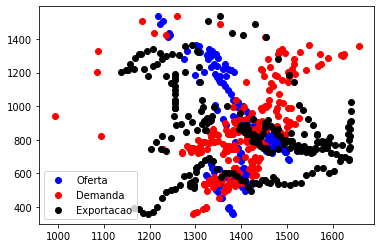

In [221]:
import matplotlib.pyplot as plt
import numpy as np

# plt.style.use('_mpl-gallery')

# make data
x = df_temp['D_exports']
y = df_temp['D_price']

# plot
fig, ax = plt.subplots()

ax.scatter(d.predict(), df_temp['D_price'], label='Oferta', color='b')
ax.scatter(o.predict(), df_temp['D_price'], label='Demanda', color='r')

ax.scatter(df_temp['D_exports'], df_temp['D_price'], label='Exportacao', color='k')

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.legend()
plt.show()

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\1296184498.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


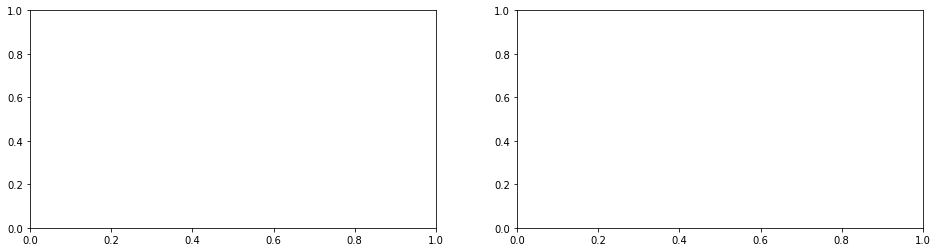

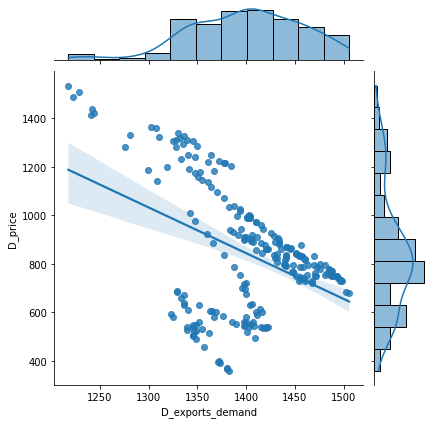

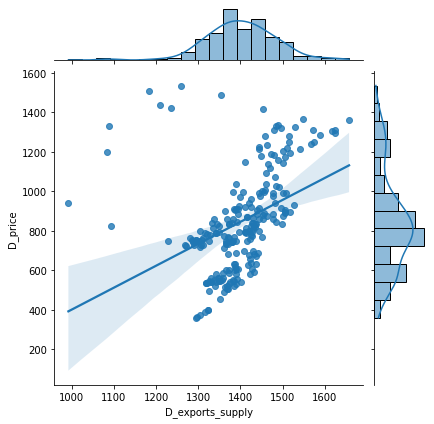

In [230]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1 = sns.jointplot(x=df_temp['D_exports_demand'], y=df_temp['D_price'], kind='reg', ax=ax1)

ax2 = sns.jointplot(x=df_temp['D_exports_supply'], y=df_temp['D_price'], kind='reg', ax=ax2)
fig.show()

In [220]:
df_temp

,D_exports,D_price,index_mundi_dap,world_income,D_exports_demand,D_exports_supply
date,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1429.385811
...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1297.619985


In [232]:
# EQ Reduzida

EXP = 'D_exports'
PRIC = 'D_price'
df = df_temp.copy()
df['const'] = 1


y1 = df[PRIC]
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['D_exports_demand']]
ols_model = sm.OLS(y1,X1)
ols_results = ols_model.fit()
ols_results.sum



In [198]:
ols_model.predict(df_temp['D_exports_supply'])

ValueError: nobs required when x is None

In [143]:
# df_temp['p_d'] = d.params['const'] + d.params[EXP]*df_temp[EXP] + d.params['world_income']*df_temp['world_income']
df_temp['x'] = 0 
for k, v in d.params.items():
    if k == 'const':
        df_temp['x'] = df_temp['x'] +  v
    else:
        df_temp['x'] = df_temp['x'] +  v*df_temp[k]
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\2820734198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['x'] = 0
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\2820734198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['x'] = df_temp['x'] +  v
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_31736\2820734198.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,exp_total,price_total_exp,index_mundi_dap,world_income,p_d,x
date,,,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62,5741.092891,5741.092891
2020-11-30,7392.21,969.754661,359.63,733.87,6128.937020,6128.937020
2020-10-31,7407.16,868.786850,357.10,737.12,6460.413383,6460.413383
2020-09-30,7422.11,854.031898,358.38,740.37,6545.003893,6545.003893
2020-08-31,7437.06,809.940713,341.88,743.62,6713.603922,6713.603922
...,...,...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42,3271.754302,3271.754302
2002-03-31,3123.33,371.064871,149.75,383.43,3278.282203,3278.282203
2002-02-28,3095.25,371.687118,150.25,382.43,3263.473496,3263.473496


In [130]:
df_temp

,exp_total,price_total_exp,index_mundi_dap,world_income
date,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62
2020-11-30,7392.21,969.754661,359.63,733.87
2020-10-31,7407.16,868.786850,357.10,737.12
2020-09-30,7422.11,854.031898,358.38,740.37
2020-08-31,7437.06,809.940713,341.88,743.62
...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42
2002-03-31,3123.33,371.064871,149.75,383.43
2002-02-28,3095.25,371.687118,150.25,382.43


In [103]:
y1 = df['price_total_exp']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', 'world_income', 'index_mundi_dap']]
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
p_hat = lr_modelo.predict(X1)

In [106]:
lr_modelo.coef_

array([0.        , 0.64649218, 0.88549171])